In [1]:
from torchvision.datasets.fakedata import transforms
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets

tranining_data = datasets.MNIST(
    root = "/content/MNIST",
    train = True,
    download= True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]),
)
test_data = datasets.MNIST(
    root = "/content/MNIST",
    train = False,
    download= True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]),
)


100%|██████████| 9912422/9912422 [00:00<00:00, 99508893.40it/s]

Extracting /content/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 39847267.71it/s]


Extracting /content/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 72497420.16it/s]

Extracting /content/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 20572925.24it/s]


Extracting /content/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/MNIST/raw



In [2]:
train_dataloader = DataLoader(tranining_data,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=64,shuffle=True)


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


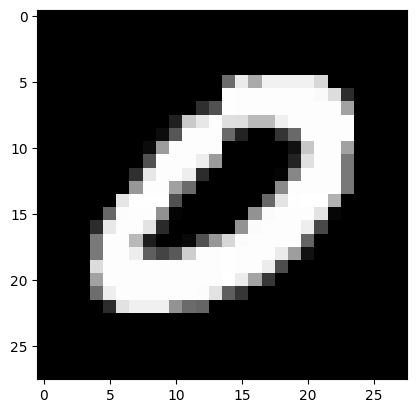

Label: 0


In [3]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [4]:
from torch import nn
import torch.nn.functional as F
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class mymoudle(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,10,kernel_size=5)
    self.conv2 = nn.Conv2d(10,20,kernel_size=3)
    self.conv2_drop = nn.Dropout2d()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(500,60),
        nn.ReLU(),
        nn.Linear(60,10),

    )
  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x),2,2))
    x = F.relu(F.max_pool2d(self.conv2(x),2,2))
    x = x.view(-1,500)
    x = self.linear_relu_stack(x)
    return F.log_softmax(x,dim=1)



Using cuda device


In [5]:
#这里设置了epoch与优化器，调整优化方法、动量、学习率
import torch.optim as optim
network = mymoudle().to(device)
#optimizer = optim.SGD(network.parameters(),lr=0.001,momentum=0.5)
optimizer = optim.Adam(network.parameters())
epoch =5

In [6]:

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_dataloader.dataset) for i in range(epoch+1)]
print(test_counter)
def train_loop(epoch):
  network.train()
  for batch_idx, (data,target) in enumerate(train_dataloader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss =  F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                          len(train_dataloader.dataset),
                                          100. * batch_idx / len(train_dataloader),
                                          loss.item()))
    train_losses.append(loss.item())
    train_counter.append((batch_idx * 64) + ((epoch - 1) * len(train_dataloader.dataset)))
    torch.save(network.state_dict(), './model.pth')
    torch.save(optimizer.state_dict(), './optimizer.pth')

[0, 60000, 120000, 180000, 240000, 300000]


In [7]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_dataloader:
      data, target = data.to(device), target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1]#返回索引
      correct += pred.eq(target.data.view_as(pred)).sum()#比较pred与target的函数，对应位置是否相同
  test_loss /= len(test_dataloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.322000
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.207084
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.148291
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.067101
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.077707
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.199983
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.109476
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.147702
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.083353
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.138576

Test set: Avg. loss: 0.0677, Accuracy: 9774/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.043593
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.016649
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.036354
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.062446
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.065597
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.157338
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.078214
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.007191
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.088096
Trai

Text(0, 0.5, 'negative log likelihood loss')

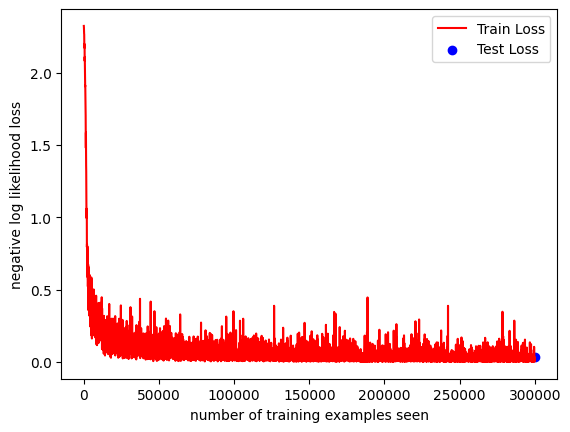

In [8]:
for epoch in range(1, epoch+1):
    train_loop(epoch)
    test()
fig = plt.figure()
plt.plot(train_counter,train_losses,color='red')
plt.scatter(test_counter[1:],test_losses,color='blue')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')


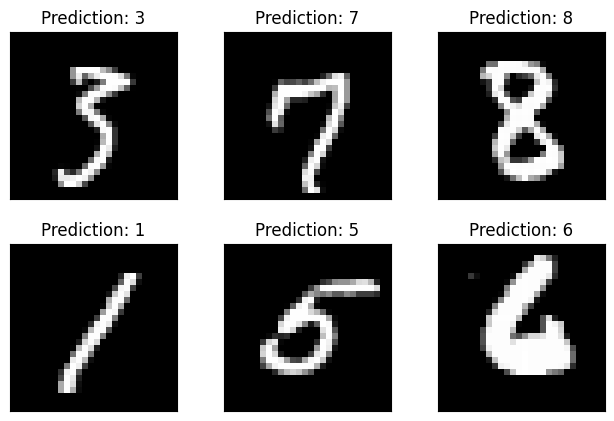

In [9]:
examples = enumerate(test_dataloader)#数据索引化
batch_idx, (example_data, example_targets) = next(examples)
with torch.no_grad():
  example_data_gpu, example_targets = example_data.to(device), example_targets.to(device)
  output = network(example_data_gpu)
fig = plt.figure()

for i in range(6):
    plt.subplot(2, 3, i + 1)#创建一个子图，并指定子图的位置（2行3列）
    plt.tight_layout()#调整子图之间的间距
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    plt.xticks([])
    plt.yticks([])
plt.show()